# First NLP assignment

The aim of this assignment is to perform POS tagging using neural architectures.

In particular, the task is the following: given a corpus of documents, predict the POS tag for each word.

## Preliminary steps:

All the libraries that we will use are imported in this section:

In [198]:
import os
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation

from matplotlib import pyplot as plt  #  gather visual information


## Text libraries
import gensim  #  glove embeddings
import gensim.downloader  #  glove embeddings
from gensim.models import KeyedVectors

## Our custom modules
# They will be used for ....
import data_setup as ds
import utils as ut

from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support as prfs
print("Done.")

Done.


### Enviroment variables


In [199]:
URL = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'
DATASET_NAME = "dependency_treebank"
STARTING_FOLDER = 'Dataset'
SEEDS = [42,1337,2023]
DATA_FOLDER = os.path.join(os.getcwd(), STARTING_FOLDER , "Original")

### Setting seed

In [200]:
ut.ensure_reproducibility(42)

## TASK 1: Download the corpus, encode it in a dataframe, and split it in train, val and test.

**Corpus**:
Ignore the numeric value in the third column, use only the words/symbols and its label.

### Instructions

* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

### First, let's download the corpus:

In [201]:
ds.download_data(DATA_FOLDER,URL) 

Successful download
Successful extraction


### Visualizing the structure of a document

We know that a document is composed of 3 columns, in particular:
* The first one contains the words/symbols,
* The second contains the POS (label) of the word in the first column,
* The last one contains a number which need to be ignored.

So, let's  display an example to get a better idea of its structure.

In [202]:
FILE_FOLDER = os.path.join(DATA_FOLDER, DATASET_NAME)
file_path = os.path.join(FILE_FOLDER, "wsj_0001.dp")
if os.path.isfile(file_path):
    print("Example of a single file:\n")
    with open(file_path, mode="r", encoding="utf-8") as text_file:
        text = text_file.read()
        print(text)

Example of a single file:

Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8

Mr.	NNP	2
Vinken	NNP	3
is	VBZ	0
chairman	NN	3
of	IN	4
Elsevier	NNP	7
N.V.	NNP	12
,	,	12
the	DT	12
Dutch	NNP	12
publishing	VBG	12
group	NN	5
.	.	3



### Encoding the corpus into a pandas dataframe

Now, we are going to creating a dataframe containing the words and the labels.

The dataframe will be structured with the following columns: 'words', 'labels', 'file id', 'sentence's number', 'split'.

The words are lowered before getting added to the dataframe, in this way we anticipate and simplify the pre-processing step for the 'text encoding' part.

In [203]:
df = ds.process_files_to_dataframe(FILE_FOLDER)
df.head()

,word,label,file_id,num_sentence,split
0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",0001,1,train
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",0001,2,train
2,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",0002,1,train
3,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",0003,1,train
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",0003,2,train


### Splitting the dataframe
**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

In [204]:
# splitting the dataframe in train, validation, test
df_train = df.loc[df['split']=="train"].reset_index(drop=True)
df_val = df.loc[df['split']=="val"].reset_index(drop=True)
df_test = df.loc[df['split']=="test"].reset_index(drop=True)

df_train.head()

,word,label,file_id,num_sentence,split
0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",0001,1,train
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",0001,2,train
2,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",0002,1,train
3,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",0003,1,train
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",0003,2,train


### Data inspection

First, let's look the general structure of the dataframes

In [205]:
print(f'- Training set has the shape: {df_train.shape}')
print(f'- Validation set has the shape: {df_val.shape}')
print(f'- Testing set has the shape: {df_test.shape}')

- Training set has the shape: (1963, 5)
- Validation set has the shape: (1299, 5)
- Testing set has the shape: (652, 5)


#### Labels distribution

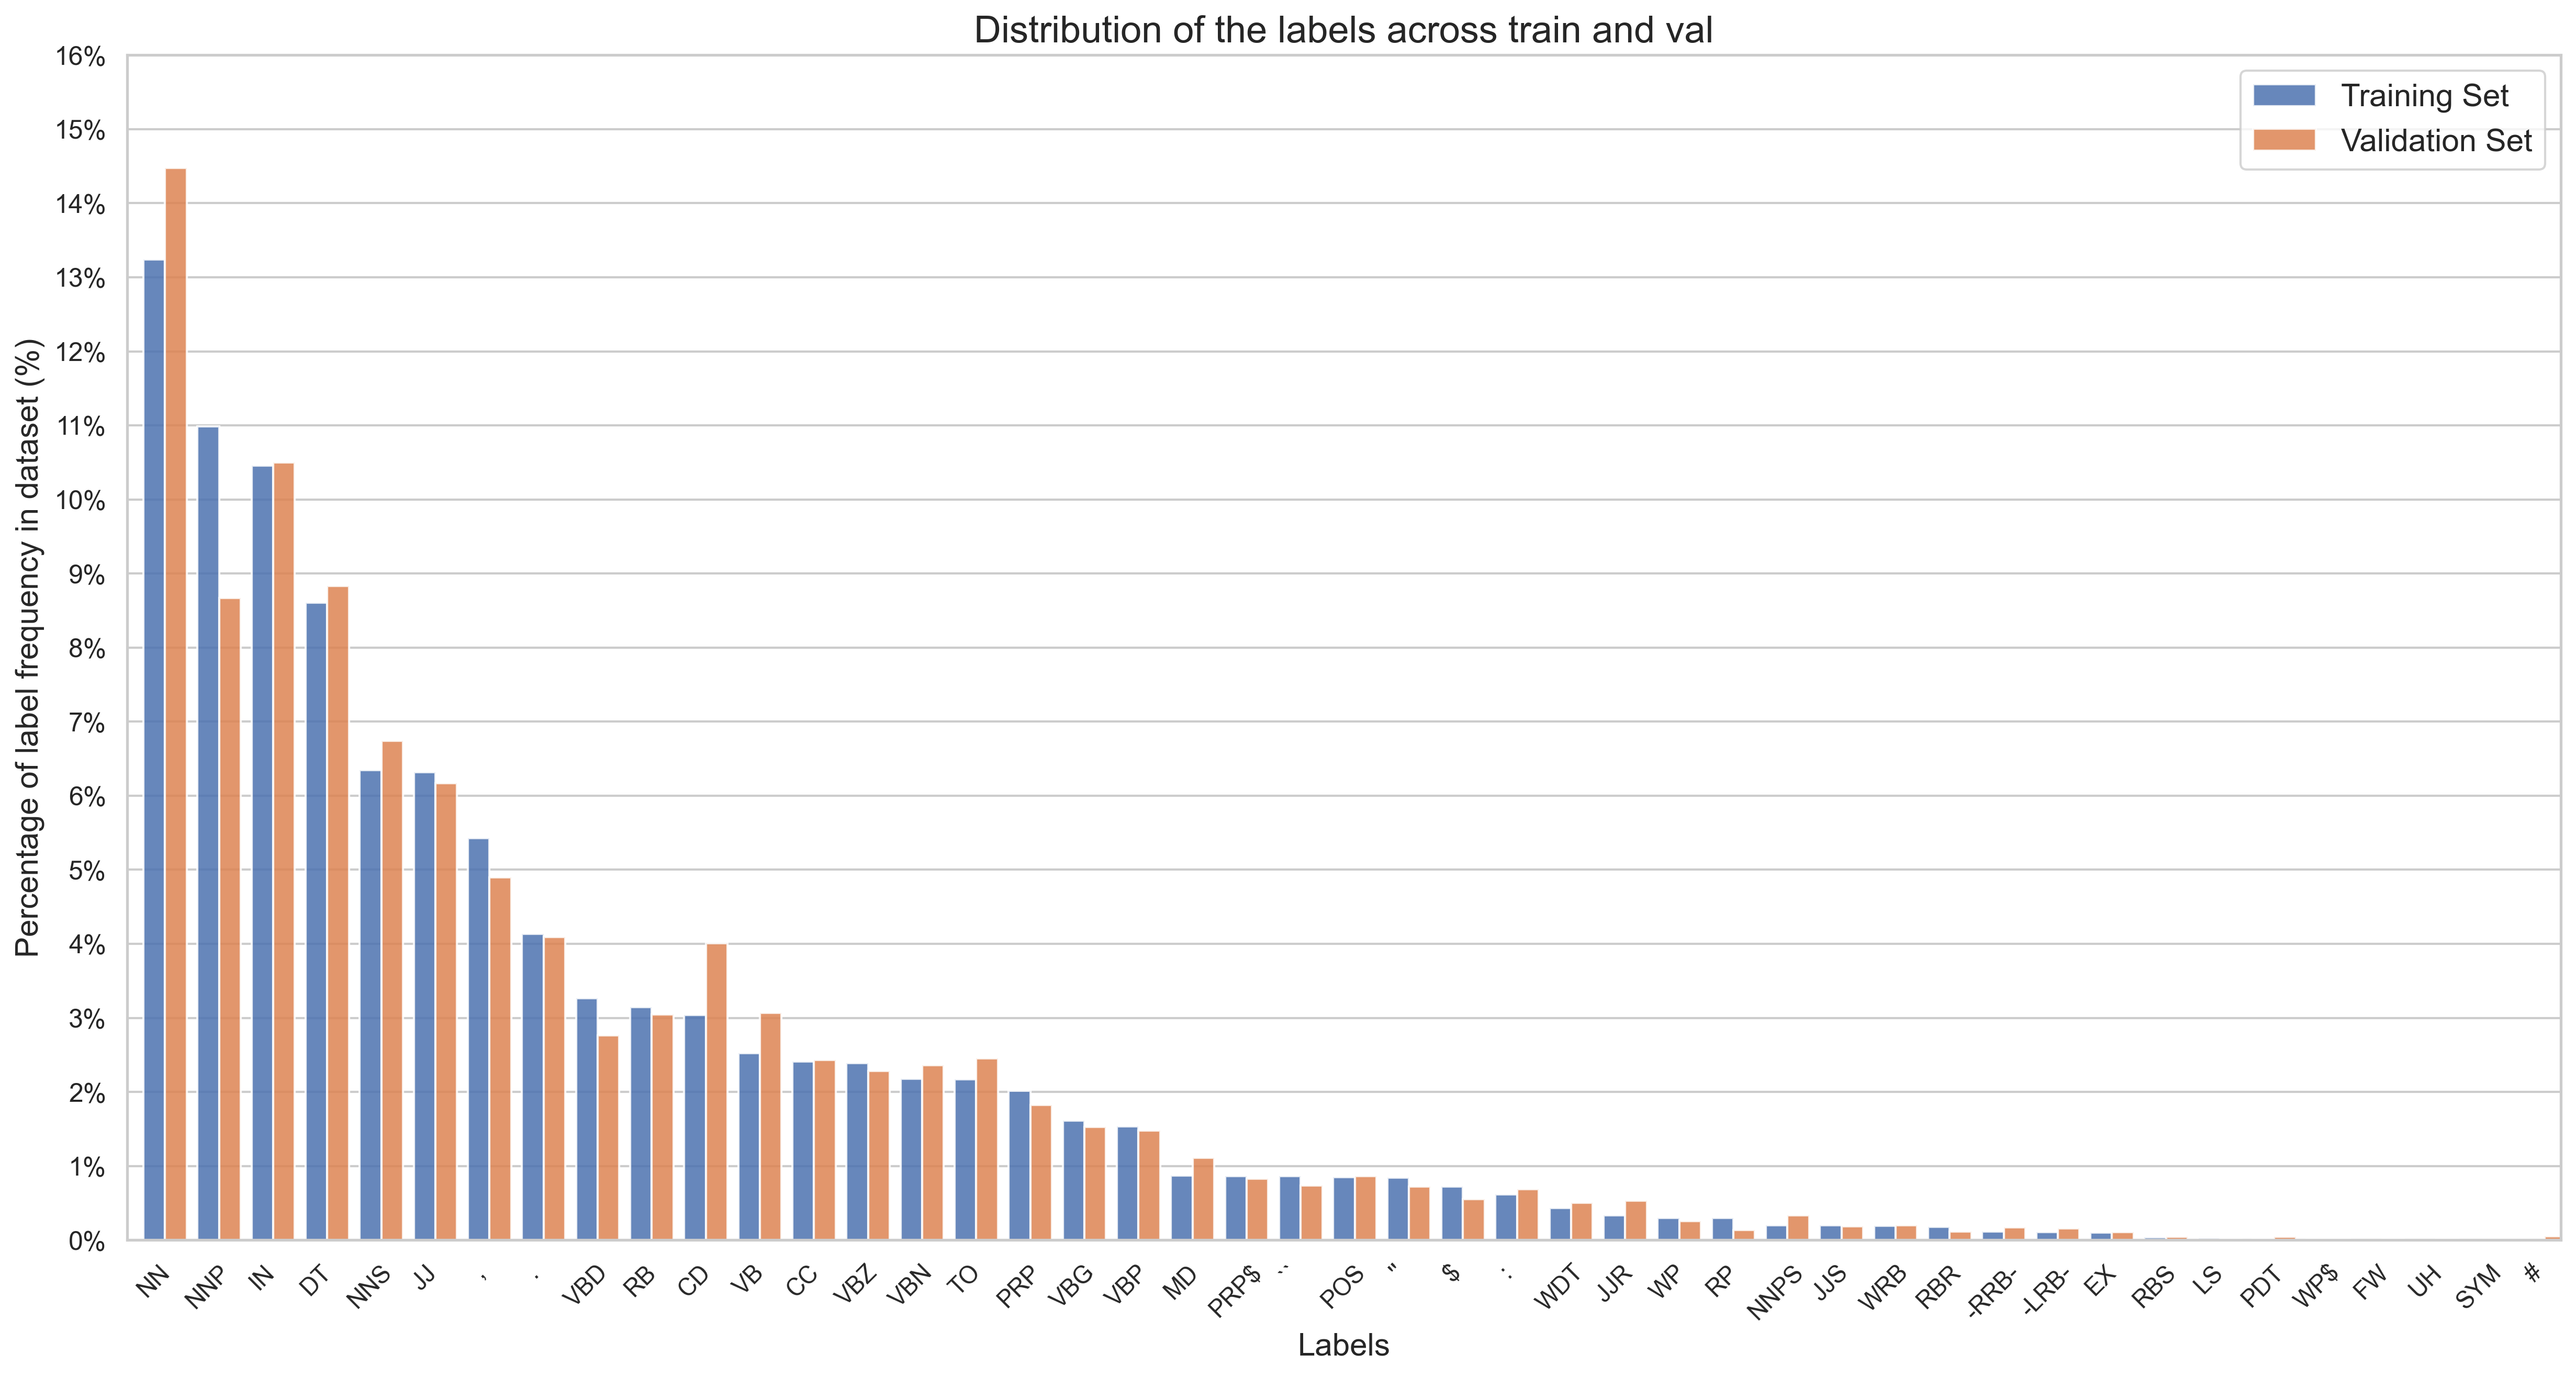

In [206]:
ut.barplot_label_distr(df_train,df_val)

#### Sentences length distribution

Max sentence lenght in the train set: 249
Max sentence lenght in the val set: 81
Max sentence lenght in the test set: 58


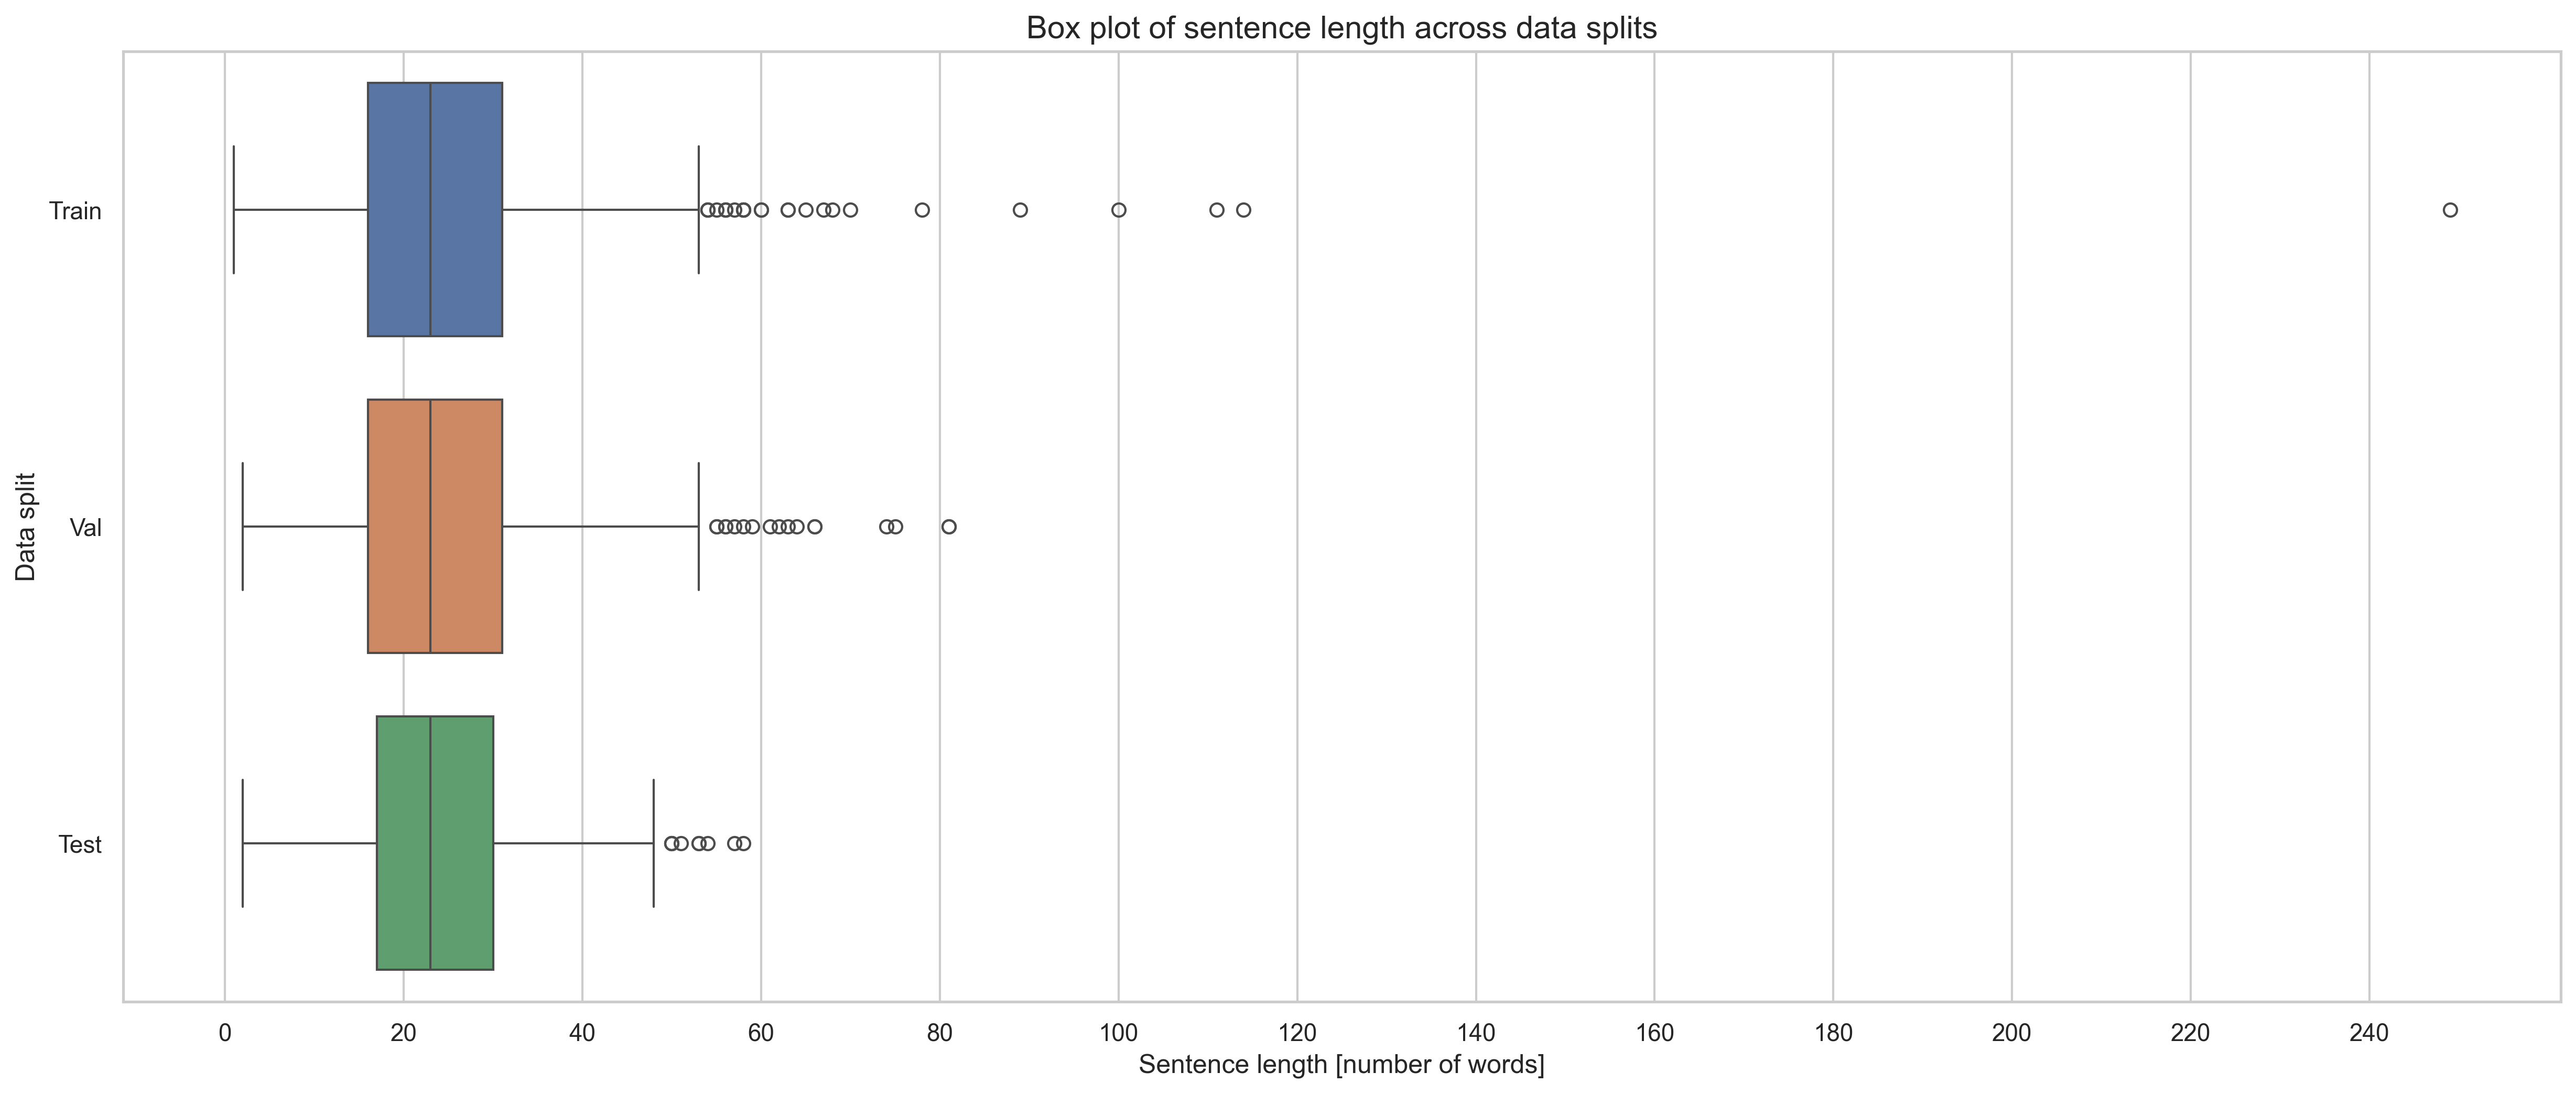

In [207]:
ut.boxplot_sents_len(df_train,df_val,df_test)

We will pad train, val and test to the max sentence length across the three splits, this is the "safest" choice one could apply. A more memory efficient, albeit less rigoruous, choice could have been to pad everything to 120 (greater than any sentence in val and test set and train except the  outlier sentence with length 249) truncating only the single long sample in train set. 

In order to follow a more methodical approach in the tackling of the assignment we have chosen to just pad everything to max length.

In [208]:
MAX_SENTENCE_LENGTH = 249 
print(f'Chosen max sequence length: {MAX_SENTENCE_LENGTH}')

Chosen max sequence length: 249


## Task 2: Text encoding

### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

### Glove embeddings
Now we have to embed the words using GloVe embeddings.

First, let's download and unzip Glove, and load pre-trained Glove vectors. For our purposes we deemed 100 a good enough size for a nice trade-off between time to train and performance.

Sezione in cui vengono scaricati gli embedding di glove nella cartella apposta, estratti e rimossi i file non necessari (embedding glove 50,300,....)

In [209]:
EMBEDDING_DIM = 100

In [210]:
# If else scarica glove se non esiste la dir glove6B 

glove_file = f'glove6B\\glove.6B.{EMBEDDING_DIM}d.txt'
glove_file_path = os.path.join(os.getcwd(), glove_file)
glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

### Building the vocabulary

Let's create a class Vocabulary for better handling the dictionaries for this task.

In [211]:
import vocab

### OOV analysis

#### Words overview

First of all, let's create our vocabolary and import the gensim pre-trained model that we previously downloaded.

In [212]:
glove_voc = vocab.Vocabulary()
glove_voc.import_from_glove(glove_model)

In [213]:
glove_voc.word2id

OrderedDict([('the', 2),
             (',', 3),
             ('.', 4),
             ('of', 5),
             ('to', 6),
             ('and', 7),
             ('in', 8),
             ('a', 9),
             ('"', 10),
             ("'s", 11),
             ('for', 12),
             ('-', 13),
             ('that', 14),
             ('on', 15),
             ('is', 16),
             ('was', 17),
             ('said', 18),
             ('with', 19),
             ('he', 20),
             ('as', 21),
             ('it', 22),
             ('by', 23),
             ('at', 24),
             ('(', 25),
             (')', 26),
             ('from', 27),
             ('his', 28),
             ("''", 29),
             ('``', 30),
             ('an', 31),
             ('be', 32),
             ('has', 33),
             ('are', 34),
             ('have', 35),
             ('but', 36),
             ('were', 37),
             ('not', 38),
             ('this', 39),
             ('who', 40),
             ('t

First of all, let's have a look of the words in the train set which are not present in *GloVe6B*.

In [214]:
oovs_train = np.array(glove_voc.get_OOV_words(df_train['word']))
nb_train_oov = len(oovs_train)
print('Words in the training set not present in GloVe:', nb_train_oov)
print(oovs_train[:10])

Words in the training set not present in GloVe: 359
['detective-story' 'home-market' 'test-coaching' 'higher-salaried'
 'moleculon' '-rrb-' 'delwin' 'sanderoff' '16.125' 'foreign-led']


By looking at the above cell, we can see that the elements which are not present in GloVe are:
1. typos which are of two types: 
    1. mispelled words
    2. wrongly inserted words with the following symbols "/", "\\" repeated a number of times
2. numbers
3. compound words separated by the symbol "-". 

As for the typos we will ignore them as per asked by the assignment specifications.

Now we will inspect how much these the last two occur in the train set in order to understand which of these requires an ad-hoc approach in the embedding.

##### Percentage of types of OOV words in training set

In [215]:
# Percentage of OOV compounds 
pctg_oov_dash_tr = ut.detect_pctg_oovs(oovs_train,'-')

print(f'- Percentage of compound oovs in train set: {pctg_oov_dash_tr:.2f}%')

# Percentage of OOV numbers 
pctg_oov_numb_tr = ut.detect_pctg_oovs(oovs_train,'.') + ut.detect_pctg_oovs(oovs_train,',')
print(f'- Percentage of number oovs in train set:   {pctg_oov_numb_tr:.2f}%')

- Percentage of compound oovs in train set: 56.82%
- Percentage of number oovs in train set:   13.37%


From these percentages we can quickly see the numbers are negligible as OOV, whereas compound words are almost half of the OOVs. Therefore we will deal with them performing an average embedding of each of the subwords which are divided by a hyphen in order to also deal with multi-compound words.

### Vocabulary definition

#### Handling of OOV tokens
The assignment requests the following procedure:

1. Create the starting vocabulary with the words contained in the *GloVe6B* vocabulary: `glove_voc`

2. Add to the starting vocabulary the  words from the training set which are not present in the  *GloVe6B* vocabulary:   `train_voc` = `glove_voc` + `oov_train`

3. The vocabulary which we will use is `train_voc` because the words in validation and test set that are not present in `train_voc` will be considered OOV words and will be represented as a special token `UNK`. 

Now we extend the vocabulary with these OOV words and repeat for the validation and the test sets.

Train set vocabulary

In [216]:
train_voc = glove_voc.copy()
train_voc.add_from_df(df_train['word'])

(Inserisci commento su assert)

In [217]:
assert(len(train_voc.word2id) == len(glove_voc.word2id)+len(oovs_train))
assert(len(train_voc.id2word) == len(glove_voc.id2word)+len(oovs_train))

Compute OOV for validation set

In [218]:
oovs_val = np.array(train_voc.get_OOV_words(df_val['word']))
print('OOV in the validation set: ', len(oovs_val))
print(oovs_val[:10])

OOV in the validation set:  189
['boogieman' '1937-40' '35564.43' 'news-american' 'industry-supported'
 'citizen-sparked' 'prevalance' '8.575' 'middle-ground' 'much-larger']


Compute OOV for test set

In [219]:
oovs_test = train_voc.get_OOV_words(df_test['word'])

print('OOV in the test set: ', len(oovs_test))
print(oovs_test)

OOV in the test set:  140
['protein-1', '55-a-share', 'life-of-contract', '131.01', '5.2180', 'larger-than-normal', '361.8', 'prudential-bache', 'corn-buying', 'colorliner', '3436.58', 'several-year', 'heavy-truck', '83,206', 'bankruptcy-law', '38.875', 'house-senate', '1206.26', 'constitutional-law', 'arbitrage-related', '11-month-old', 'mariotta', 'minimum-wage', '372.14', '494.50', 'property\\/casualty', 'exxon-owned', '220.45', 'acquisition-minded', '1.916', '2,050-passenger', '47.125', 'high-rolling', '170,262', '734.9', 'information-services', 'hadson', 'interleukin-3', 'inter-tel', 'conn.based', 'garden-variety', '129.91', 'crookery', 'waertsilae', 'yoshihashi', 'cost-control', 'ex-dividend', '19-month-old', 'copper-rich', 'waymar', 'noncompetitively', 'intelogic', '11,390,000', '300-a-share', '45-a-share', 'sewing-machine', '811.9', '0.0085', '387.8', '6,799', '154,240,000', 'txo', 'johnson-era', 'prior-year', 'disputada', 'louisiana-pacific', 'lentjes', '5,699', '1.637', 'head

#### Labels overview

Now, let's have a look at the POS tags present in this corpus:

In [220]:
train_labels_cat = np.concatenate(df_train['label'].values)
val_labels_cat = np.concatenate(df_val['label'].values)
test_labels_cat = np.concatenate(df_test['label'].values)


unique_train_labels = np.unique(train_labels_cat)
unique_val_labels = np.unique(val_labels_cat)
unique_test_labels =  np.unique(test_labels_cat)

all_labels = np.concatenate([train_labels_cat,val_labels_cat,test_labels_cat])
unique_labels = np.unique(np.concatenate([unique_train_labels,unique_val_labels,unique_test_labels]))

In [221]:
print(f'Number of tags in the dataset: {len(list(unique_labels))} ')
print(f'List of the tags in the dataset: \n {list(unique_labels)} ')

Number of tags in the dataset: 45 
List of the tags in the dataset: 
 ['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``'] 


#### Understanding punctuation and symbols
We need to the remove the indices associated with the following tags:

Punctuation:

- -LRB- → "Left Round Bracket" → "({"
- -RRB- → "Right Round Bracket" → "){"
- $
- ' '
- \#
- ,
- .
- :

Symbols:
- SYM → Symbol
- ``

### Show labels present in train and not val/test

#### Tags present in train and not in val

In [222]:
print("- Tags that are occur in the train set and not in validation set:",
      list(set(unique_train_labels).difference(set(unique_val_labels))))

- Tags that are occur in the train set and not in validation set: ['SYM']


#### Tags present in train and not in test

In [223]:
print("- Tags in that occur in train set which and not in test set:",
      list(set(unique_train_labels).difference(set(unique_test_labels))))

- Tags in that occur in train set which and not in test set: ['SYM', 'FW', '#', 'LS', 'UH']


### Text encoding


Now, we're asked to encode our sentences in a numeric format so we can pass them as input to our neural networks.

(Inserisci commento su encoding)

In [224]:
X_train_encoded = train_voc.encode(df_train['word'])
X_val_encoded = train_voc.encode(df_val['word'])
X_test_encoded = train_voc.encode(df_test['word'])

In order to encode the pos tagging labels, we're going to use the tokenizer of keras.

In [225]:
# Libraries for performing the input preparation of the network and the training
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Bidirectional, Embedding, Dense, LSTM, TimeDistributed
from keras import backend as K
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support as prfs


In [226]:
PAD_ID = 'PAD' # to be removed
labels_tokenizer = Tokenizer() # defining the tokenizer
labels_tokenizer.fit_on_texts([unique_labels.tolist()]) # fitting the tokenizer on the list of unique labels

In [227]:
y_train_encoded = ut.label_encoder(df_train['label'], labels_tokenizer)
y_val_encoded = ut.label_encoder(df_val['label'], labels_tokenizer)
y_test_encoded =  ut.label_encoder(df_test['label'], labels_tokenizer)

In [228]:
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', df_train['word'][0], '\n')
print('Y: ', df_train['label'][0], '\n')
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_train_encoded[0], '\n')
print('Y: ', y_train_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.'] 

Y:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'] 

** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [5031, 400002, 3, 4980, 84, 169, 3, 45, 1431, 2, 536, 21, 9, 128566, 371, 2345, 1265, 4] 

Y:  [21, 21, 4, 10, 23, 15, 4, 19, 35, 11, 20, 14, 11, 15, 20, 21, 10, 7] 



#### Truncation and padding

We will pad everything to max length as explained in the section `Data inspection` 

In [229]:
# MAX_SENTENCE_LENGTH = 249

X_train = pad_sequences(X_train_encoded, maxlen=MAX_SENTENCE_LENGTH, padding="post", truncating="post")
X_val = pad_sequences(X_val_encoded, maxlen=MAX_SENTENCE_LENGTH, padding="post", truncating="post")
X_test = pad_sequences(X_test_encoded, maxlen=MAX_SENTENCE_LENGTH, padding="post", truncating="post")

In [230]:
y_train = pad_sequences(y_train_encoded, maxlen=MAX_SENTENCE_LENGTH, padding="post", truncating="post")
y_val = pad_sequences(y_val_encoded, maxlen=MAX_SENTENCE_LENGTH, padding="post", truncating="post")
y_test = pad_sequences(y_test_encoded, maxlen=MAX_SENTENCE_LENGTH, padding="post", truncating="post")

Now we have our words and our labels represented as integers. But we need a more sophisticated representation for our neural model.
For this reason we're going to represent the words using the glove dictionary previously downloaded, while to represent the tags we're going to use the one-hot encoding.

#### Words embedding
As previously mentioned, for most of the words in our corpus, we're going to use the glove embedding. Unfortunately, we don't have a neural representation for OOV words in the train set, for this reason we decided to proceed as following:

*   By default, to represent these OOV words we're going to select a random value sampled from a uniform distribution in the range $[-0.5,0.5]$ (**Vedi se ha senso dare un numero specifico sennò dai [-1,1] !!!!**).
*   Instead, a compound word separeted by '-' will be splitted in its sub-words and its representation will be the sum of the most similar embedding, if it exists, or the default embedding, of those word.



In [231]:
VOC = train_voc
VOCABULARY_DIM = len(VOC.word2id)+2

In [232]:
embedding_weights = ut.generate_weights(VOC,VOCABULARY_DIM,EMBEDDING_DIM,glove_model)

### Embedding layer definition

#### Labels encoding: one-hot encoding
 To represent the tags we're going to use the one-hot encoding method since the number of different POS tags labels is small, and the LSTM model will learn autonomously its internal representation of these labels.

In [233]:
# train set
y_train = y_train.tolist()
y_train = to_categorical(y_train)
NR_CLASSES = y_train.shape[2]

# validation set
y_val = y_val.tolist()
y_val = to_categorical(y_val, num_classes=NR_CLASSES)

# test set
y_test = y_test.tolist()
y_test = to_categorical(y_test, num_classes=NR_CLASSES)

In [234]:
print(f'Number of classes: {NR_CLASSES}')

Number of classes: 46


## Task 3: Model definition

Now, we have to define the neural POS tagger.

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.


**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

In [235]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_val.shape))
print('Shape of output sequences: {}'.format(y_val.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(y_test.shape))

TRAINING DATA
Shape of input sequences: (1963, 249)
Shape of output sequences: (1963, 249, 46)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (1299, 249)
Shape of output sequences: (1299, 249, 46)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (652, 249)
Shape of output sequences: (652, 249, 46)


### F1-score

In [236]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Hyper-parameters setting

In [237]:
epochs = 100
batch_size = 256  #128
learning_rate = 0.05 #0.001
patience = 10
factor = 0.5

metrics = ["accuracy", f1_m]

models = {}

In [238]:
models_path = os.path.join(os.getcwd(), 'Models')
if not os.path.exists(models_path):
    os.makedirs(models_path)

In [239]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=factor, patience=patience//3, min_lr=1e-7)
]

def get_checkpoint_path(model):
  checkpoint_name = f'{model.name}cp.ckpt'
  checkpoint_path = os.path.join(os.getcwd(), 'Models', checkpoint_name)
  checkpoint_dir = os.path.dirname(checkpoint_path)
  return checkpoint_path

def get_checkpoint(model, monitor: str = "val_loss"):
  filepath = get_checkpoint_path(model)
  cp =  tf.keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        monitor = monitor,
        save_best_only = True,
        save_weights_only = True,
        mode = 'max',
        )
  return cp

history = {}

### Embedding layer definition

In [240]:
from keras.layers import  Masking


In [254]:
embedding_layer = Embedding(
    input_dim = VOCABULARY_DIM,
    output_dim = EMBEDDING_DIM,
    weights = [embedding_weights],
    input_length= MAX_SENTENCE_LENGTH,
    mask_zero = True,
    trainable = False
);

### Baseline: Bidirectional LSTM with a Dense layer

In [182]:
baseline_name = 'baseline'

In [255]:
input_layer = keras.Input((None,))
masking_layer = Masking(mask_value=0.0)(input_layer)
emb_layer = embedding_layer(masking_layer)
lstm_layer = Bidirectional(LSTM(100, return_sequences=True))(emb_layer)
dense_layer = TimeDistributed(Dense(NR_CLASSES))(lstm_layer)
final_layer = keras.layers.Activation('softmax')(dense_layer)

In [256]:
models[baseline_name] = keras.Model(input_layer, final_layer, name=baseline_name)
models[baseline_name].compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
models[baseline_name].summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 masking_5 (Masking)         (None, None)              0         
                                                                 
 embedding_2 (Embedding)     (None, None, 100)         40036100  
                                                                 
 bidirectional_9 (Bidirectio  (None, None, 200)        160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, None, 46)         9246      
 tributed)                                                       
                                                                 
 activation_6 (Activation)   (None, None, 46)          0  

### Model 1: additional LSTM layer

In [245]:
lstm_name = 'doubleLSTM'

In [187]:
input_layer = keras.Input((None,))
masking_layer = Masking(mask_value=0.0)(input_layer)
emb_layer = embedding_layer(masking_layer)
lstm_layer1 = Bidirectional(LSTM(100, return_sequences=True))(emb_layer)
lstm_layer2 = Bidirectional(LSTM(64, return_sequences=True))(lstm_layer1)
dense_layer = TimeDistributed(Dense(NR_CLASSES))(lstm_layer2)
final_layer = keras.layers.Activation('softmax')(dense_layer)

In [189]:
models[lstm_name] = keras.Model(input_layer, final_layer, name=lstm_name)
models[lstm_name].compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
models[lstm_name].summary()

Model: "doubleLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 masking_1 (Masking)         (None, None)              0         
                                                                 
 embedding (Embedding)       (None, None, 100)         40036100  
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 200)        160800    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        135680    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, None, 46)         5

### Model 2: additional Dense layer

In [190]:
dense_name = 'doubleDense'

In [191]:
input_layer = keras.Input((None,))
masking_layer = Masking(mask_value=0.0)(input_layer)
emb_layer = embedding_layer(masking_layer)
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(emb_layer)
dense_layer1 = TimeDistributed(Dense(64))(lstm_layer)
dense_layer2 = Dense(NR_CLASSES)(dense_layer1)
final_layer = keras.layers.Activation('softmax')(dense_layer2)

In [192]:
models[dense_name] = keras.Model(input_layer, final_layer, name=dense_name)
models[dense_name].compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
models[dense_name].summary()

Model: "doubleDense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 masking_2 (Masking)         (None, None)              0         
                                                                 
 embedding (Embedding)       (None, None, 100)         40036100  
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 128)        84480     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, None, 64)         8256      
 tributed)                                                       
                                                                 
 dense_3 (Dense)             (None, None, 46)          

## Task 4: Metrics

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)
* **Do not consider punctuation and symbol classes**

### Auxiliary functions

In [246]:
def get_crisp(pred1D: list[int]) -> list[int]:
  index = np.argmax(pred1D)
  pred_crisp = (np.arange(pred1D.shape[0]) == index).astype('float32')
  return pred_crisp

def get_crisps(pred3D: list[list[list[int]]]) -> list[list[list[int]]]:
  return np.apply_along_axis(get_crisp, -1, pred3D)

def one_hot_reverse(pred:list[list[list[int]]], to_crisp: bool=True) -> list[list[str]]:
  if to_crisp:
    pred_crisp = get_crisps(pred)
  pred_class = [[np.argmax(token) for token in sentence] for sentence in pred_crisp]
  return pred_class

def decoding_pred(preds:list[list[list[int]]], tokenizer: keras.preprocessing.text.Tokenizer(), to_crisp: bool=True, inverse_one_hot: bool=True) -> list[list[str]]:
  if to_crisp:
    pred_crisp = get_crisps(preds)
  if inverse_one_hot:
    pred_class = one_hot_reverse(pred_crisp)
  res = ut.label_decoder(pred_class, tokenizer)
  return res

def pred_flat(pred:list[list[int]]) -> list[int]:
  flatten = [elem for sent in pred for elem in sent]
  return flatten

In [247]:
punctuation = ['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', ' ', '``']  # All the punctuation tags in the Penn Treebank Tagset
labels_for_metrics = np.setdiff1d(unique_labels, punctuation+[PAD_ID]).tolist()  # All the non-punctuation labes
labels_for_metrics_encoded = ut.label_encoder([labels_for_metrics], labels_tokenizer)[0]

## Task 5: Training and Evaluation

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

### Training

#### Baseline: Bidirectional LSTM with a Dense layer

In [257]:
history[baseline_name] = models[baseline_name].fit(X_train, y_train,
                   validation_data = (X_val, y_val),
                   batch_size = batch_size,
                   callbacks = callbacks + [get_checkpoint(models[baseline_name], monitor='val_f1_m')],
                   epochs = epochs)

models[baseline_name].load_weights(get_checkpoint_path(models[baseline_name]))

Epoch 1/100
4/8 [==============>...............] - ETA: 20s - loss: 0.3504 - accuracy: 0.0735 - f1_m: 0.0000e+00

KeyboardInterrupt: 

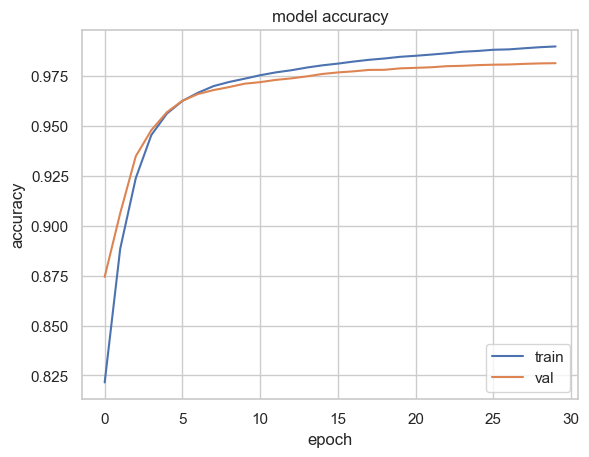

In [59]:
# visualise training history: accuracy
plt.plot(history[name].history['accuracy'])
plt.plot(history[name].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

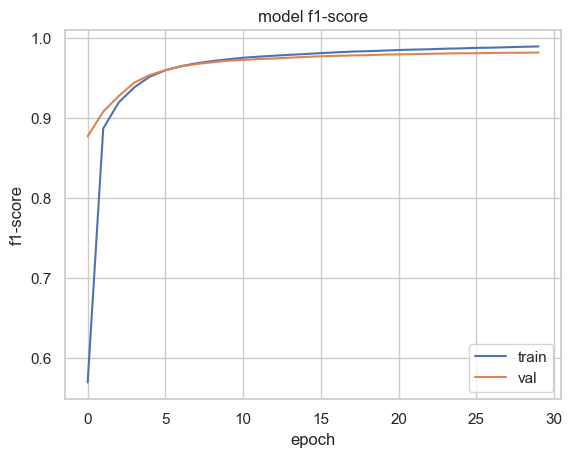

In [60]:
# visualise training history: f1-score
plt.plot(history[name].history['f1_m'])
plt.plot(history[name].history['val_f1_m'])
plt.title('model f1-score')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

#### Model 1: additional LSTM layer

In [61]:
name = 'doubleLSTM'

In [62]:
history[name] = models[name].fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                   batch_size=batch_size,
                   callbacks=callbacks,
                   epochs=epochs)

Epoch 1/30
62/62 [==============================] - 50s 474ms/step - loss: 1.0668 - accuracy: 0.8025 - f1_m: 0.7421 - val_loss: 0.5909 - val_accuracy: 0.8369 - val_f1_m: 0.8792 - lr: 0.0010
Epoch 2/30
62/62 [==============================] - 23s 373ms/step - loss: 0.4962 - accuracy: 0.8708 - f1_m: 0.8866 - val_loss: 0.3923 - val_accuracy: 0.9001 - val_f1_m: 0.9047 - lr: 0.0010
Epoch 3/30
62/62 [==============================] - 22s 352ms/step - loss: 0.3125 - accuracy: 0.9179 - f1_m: 0.9225 - val_loss: 0.2617 - val_accuracy: 0.9325 - val_f1_m: 0.9328 - lr: 0.0010
Epoch 4/30
62/62 [==============================] - 21s 334ms/step - loss: 0.2156 - accuracy: 0.9469 - f1_m: 0.9438 - val_loss: 0.1935 - val_accuracy: 0.9515 - val_f1_m: 0.9495 - lr: 0.0010
Epoch 5/30
62/62 [==============================] - 23s 372ms/step - loss: 0.1644 - accuracy: 0.9590 - f1_m: 0.9574 - val_loss: 0.1577 - val_accuracy: 0.9608 - val_f1_m: 0.9595 - lr: 0.0010
Epoch 6/30
62/62 [==============================] 

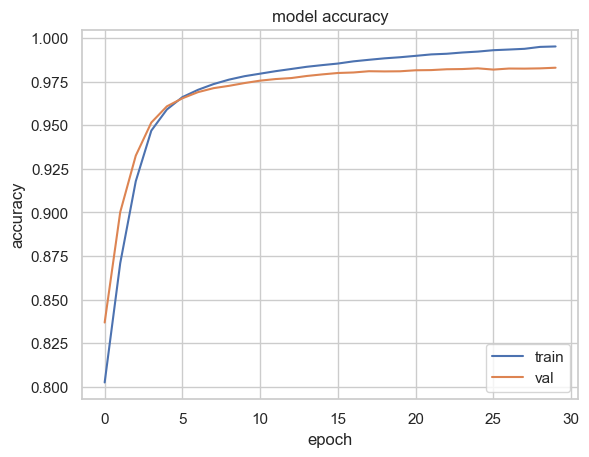

In [63]:
# visualise training history: accuracy
plt.plot(history[name].history['accuracy'])
plt.plot(history[name].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

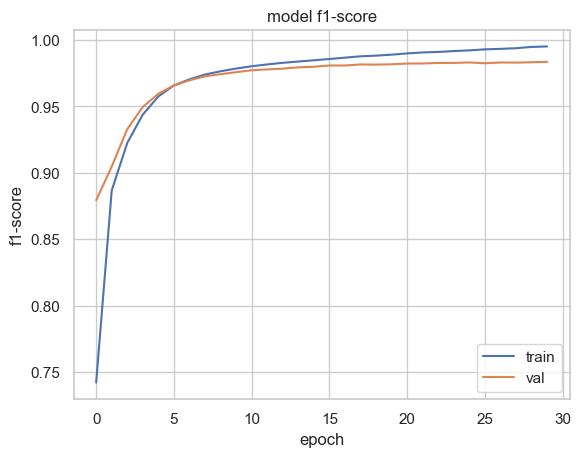

In [64]:
# visualise training history: f1-score
plt.plot(history[name].history['f1_m'])
plt.plot(history[name].history['val_f1_m'])
plt.title('model f1-score')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

#### Model 2: additional Dense layer

In [65]:
name = 'doubleDense'

In [66]:
history[name] = models[name].fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                   batch_size=batch_size,
                   callbacks=callbacks,
                   epochs=epochs)

Epoch 1/30
62/62 [==============================] - 23s 203ms/step - loss: 1.3502 - accuracy: 0.8149 - f1_m: 0.6385 - val_loss: 0.5177 - val_accuracy: 0.8707 - val_f1_m: 0.8786 - lr: 0.0010
Epoch 2/30
62/62 [==============================] - 14s 230ms/step - loss: 0.4097 - accuracy: 0.8964 - f1_m: 0.8999 - val_loss: 0.3224 - val_accuracy: 0.9162 - val_f1_m: 0.9218 - lr: 0.0010
Epoch 3/30
62/62 [==============================] - 11s 174ms/step - loss: 0.2546 - accuracy: 0.9346 - f1_m: 0.9355 - val_loss: 0.2157 - val_accuracy: 0.9433 - val_f1_m: 0.9443 - lr: 0.0010
Epoch 4/30
62/62 [==============================] - 10s 165ms/step - loss: 0.1781 - accuracy: 0.9536 - f1_m: 0.9541 - val_loss: 0.1647 - val_accuracy: 0.9562 - val_f1_m: 0.9564 - lr: 0.0010
Epoch 5/30
62/62 [==============================] - 10s 156ms/step - loss: 0.1407 - accuracy: 0.9632 - f1_m: 0.9629 - val_loss: 0.1373 - val_accuracy: 0.9641 - val_f1_m: 0.9634 - lr: 0.0010
Epoch 6/30
62/62 [==============================] 

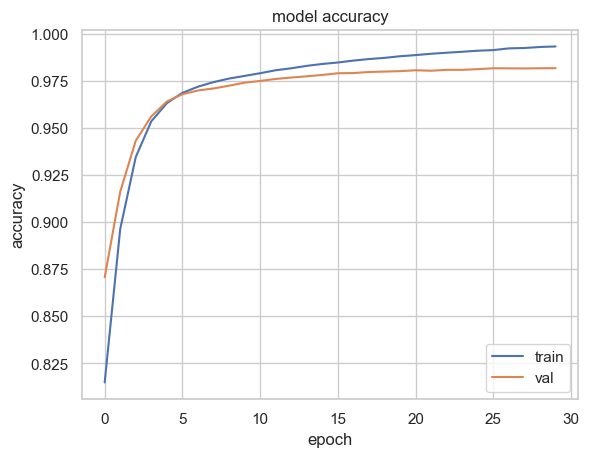

In [67]:
# visualise training history: accuracy
plt.plot(history[name].history['accuracy'])
plt.plot(history[name].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

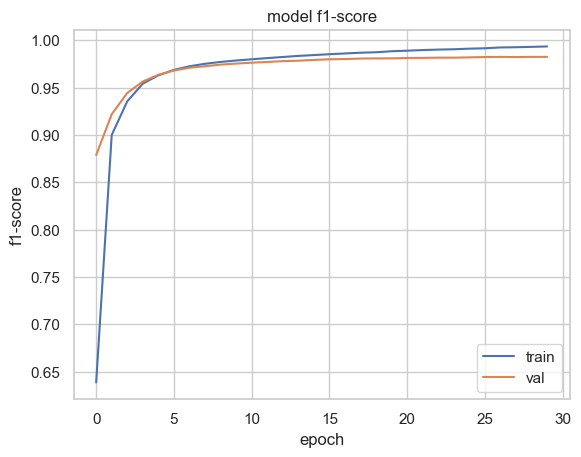

In [68]:
# visualise training history: f1-score
plt.plot(history[name].history['f1_m'])
plt.plot(history[name].history['val_f1_m'])
plt.title('model f1-score')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="lower right")
plt.show()

### Evaluation on the validation set



In [69]:
y_val_decoded = decoding_pred(y_val, labels_tokenizer)

y_val_pred_decoded = {}
for key, model in models.items():
    y_val_pred_decoded[key] = model.predict(X_val)
    y_val_pred_decoded[key] = decoding_pred(y_val_pred_decoded[key], labels_tokenizer)

41/41 [==============================] - 3s 43ms/step


#### Baseline: Bidirectional LSTM with a Dense layer

In [70]:
name = 'baseline_model'

In [71]:
y_val_true, y_val_pred_decoded[name] = get_pred_no_punctuation(y_val_decoded, y_val_pred_decoded[name], filter)

In [72]:
f1_score(y_val_true, y_val_pred_decoded[name], average='macro')

0.7075040506090509

In [73]:
pd.DataFrame(classification_report(y_val_true, y_val_pred_decoded[name], output_dict=True, zero_division=0)).T

,precision,recall,f1-score,support
-lrb-,0.821429,0.920000,0.867925,50.000000
-rrb-,0.909091,0.566038,0.697674,53.000000
PAD,0.000000,0.000000,0.000000,0.000000
cc,0.996000,0.985488,0.990716,758.000000
cd,0.972199,0.923939,0.947455,1249.000000
dt,0.989474,0.989833,0.989653,2754.000000
ex,0.944444,1.000000,0.971429,34.000000
fw,0.000000,0.000000,0.000000,2.000000
in,0.977771,0.967023,0.972367,3275.000000
jj,0.791378,0.830042,0.810249,1924.000000


#### Model 1: additional LSTM layer

In [74]:
name = 'doubleLSTM'

In [75]:
y_val_true, y_val_pred_decoded[name] = get_pred_no_punctuation(y_val_decoded, y_val_pred_decoded[name], filter)

In [76]:
f1_score(y_val_true, y_val_pred_decoded[name], average='macro')

0.7150603526805964

In [77]:
pd.DataFrame(classification_report(y_val_true, y_val_pred_decoded[name], output_dict=True, zero_division=0)).T

,precision,recall,f1-score,support
-lrb-,0.769231,0.800000,0.784314,50.000000
-rrb-,0.871795,0.641509,0.739130,53.000000
.,0.000000,0.000000,0.000000,0.000000
PAD,0.000000,0.000000,0.000000,0.000000
cc,0.998661,0.984169,0.991362,758.000000
cd,0.963666,0.934347,0.948780,1249.000000
dt,0.989855,0.992012,0.990932,2754.000000
ex,1.000000,1.000000,1.000000,34.000000
fw,0.000000,0.000000,0.000000,2.000000
in,0.982386,0.970687,0.976501,3275.000000


#### Model 2: additional Dense layer

In [78]:
name = 'doubleDense'

In [79]:
y_val_true, y_val_pred_decoded[name] = get_pred_no_punctuation(y_val_decoded, y_val_pred_decoded[name], filter)

In [80]:
f1_score(y_val_true, y_val_pred_decoded[name], average='macro')

0.6989230316998798

In [81]:
pd.DataFrame(classification_report(y_val_true, y_val_pred_decoded[name], output_dict=True, zero_division=0)).T

,precision,recall,f1-score,support
'',0.000000,0.000000,0.000000,0.000000
-lrb-,0.886792,0.940000,0.912621,50.000000
-rrb-,0.956522,0.830189,0.888889,53.000000
.,0.000000,0.000000,0.000000,0.000000
PAD,0.000000,0.000000,0.000000,0.000000
cc,0.998661,0.984169,0.991362,758.000000
cd,0.971714,0.935148,0.953080,1249.000000
dt,0.989848,0.991285,0.990566,2754.000000
ex,0.944444,1.000000,0.971429,34.000000
fw,0.000000,0.000000,0.000000,2.000000


#### F1-score: comparison

In [82]:
for key in models.keys():
    print(f"{f'[val] Model {key} f1_score (without punctuation):':<55} {f1_score(y_val_true, y_val_pred_decoded[key], average='macro')}")

[val] Model baseline_model f1_score (without punctuation): 0.7075040506090509
[val] Model doubleLSTM f1_score (without punctuation):  0.7150603526805964
[val] Model doubleDense f1_score (without punctuation): 0.6989230316998798


### Evaluation of the best model

In [135]:
y_test_decoded = decoding_pred(y_test, labels_tokenizer)

y_test_pred_decoded = {}
for key, model in models.items():
    y_test_pred_decoded[key] = model.predict(X_test)
    y_test_pred_decoded[key] = decoding_pred(y_test_pred_decoded[key], labels_tokenizer)

21/21 [==============================] - 1s 42ms/step


In [ ]:
y_test_true, y_test_pred_decoded[name] = get_pred_no_punctuation(y_test_decoded, y_test_pred_decoded[name], filter)

In [134]:
for key in models.keys():
    print(f"{f'[test] Model {key} f1_score (without punctuation):':<55} {f1_score(y_test_true, y_test_pred_decoded[key], average='macro')}")

[test] Model baseline_model f1_score (without punctuation): 0.7297670495990982
[test] Model doubleLSTM f1_score (without punctuation): 0.7429525220359207
[test] Model doubleDense f1_score (without punctuation): 0.7875208275954696


## Task 6: Error Analysis

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible)
* Comment the about errors and propose possible solutions on how to address them.